In [1]:
import numpy as np
from tqdm import tqdm
import networkx as nx
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt

In [2]:
def random_split(X, y, n, seed):
    """Equally split data between n agents"""
    rng = np.random.default_rng(seed)
    perm = rng.permutation(y.shape[0])
    X_split = np.array_split(X[perm], n)  #np.stack to keep as a np array
    y_split = np.array_split(y[perm], n)
    return X_split, y_split

# Graph implementation
def generate_graph(cluster_sizes=[100,100], pin=0.5, pout=0.01, seed=0):
    """Generate a random connected graph"""
    probs = np.array([[pin, 2 * pout, 5 * pout],[2 * pout, pin, 6 * pout],[5 * pout, 6 * pout, pin]])
    while True:
        g = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
        if nx.algorithms.components.is_connected(g):
            return g

In [3]:
def get_data(data):
    data = load_svmlight_file(data)
    return data[0].toarray(), data[1]
data = "./abalone_scale.txt"
X, y = get_data(data)


X, y = random_split(X, y, 3, 42)
X1 = X[0][:, 0:4]
X2 = X[1][:, 0: 6]
X3 = X[2][:, 0:]
y1 = y[0]
y2 = y[1]
y3 = y[2]

X_test = [np.concatenate([X[1], X[2]], axis=0), np.concatenate([X[0], X[2]], axis=0), np.concatenate([X[0], X[1]], axis=0)]
y_test = [np.concatenate((y[1], y[2])), np.concatenate((y[0], y[2])), np.concatenate((y[0], y[1]))]


subset_ranges = [np.arange(0, 4), np.arange(0, 6), np.arange(0, 8)]
subset_lengths = [subset_ranges[0].shape[0], subset_ranges[1].shape[0], subset_ranges[2].shape[0]]

X1, y1 = random_split(X1, y1, 10, 42)
X2, y2 = random_split(X2, y2, 10, 42)
X3, y3 = random_split(X3, y3, 10, 42)

In [4]:
len(X_test)

3

In [5]:
group_size = 3
cluster_sizes = [group_size, group_size, group_size]
pin = 0.5
pout = 0.1
seed = 0
alpha = 1e-2
lamda = 1e-2#1e-1#1e-3
eta =  1e-1
d0 = min(subset_lengths)
no_users = sum(cluster_sizes)
batch_size = 20
epochs = 1
it = 1000

# Set a random seed for reproducibility
seed = 17

np.random.seed(seed)
num_features = 4

In [6]:
X = [X1, X2, X3]
y = [y1, y2, y3]
input_sizes = [X1[0].shape[1], X2[0].shape[1], X3[0].shape[1]]

X_train = []
y_train = []
X_temp = []
y_temp = []


for i, cluster_size in enumerate(cluster_sizes):
    for j in range(cluster_size):

        
        X_train.append(X[i][j])
        y_train.append(y[i][j])
        
        X_temp.append(X_test[i][:, subset_ranges[i]])
        y_temp.append(y_test[i])
X_test = X_temp 
y_test = y_temp


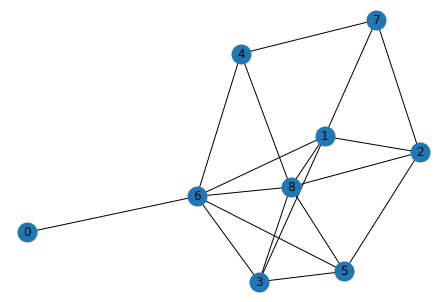

In [7]:
G = generate_graph(cluster_sizes, pin, pout, seed)
nx.draw(G, with_labels=True, node_size=100, alpha=1, linewidths=10)
plt.show()

In [8]:
def loss(w, A, b):
    z = b * np.dot(A, w)
    tmp = np.minimum(z, 0)
    loss = np.log((np.exp(tmp) + np.exp(tmp - z)) / np.exp(tmp))
    loss_sum = np.sum(loss) / len(b)
    reg = (np.linalg.norm(w) ** 2) * l2 / 2
    return loss_sum + reg


def linear_regression_loss(w, A, b):
    predictions = np.dot(A, w)
    errors = predictions - b
    mse_loss = np.mean(errors**2) / 2
    return mse_loss


def gradient(w, A, b):
    m = A.shape[0]
    bAw = b * (A @ w)
    temp = 1. / (1. + np.exp(bAw))
    res = -(A.T @ (b * temp))/m + l2 * w
    return res


def linear_regression_gradient(w, A, b):
    m = A.shape[0]
    predictions = np.dot(A, w)
    errors = predictions - b
    
    # Gradient without regularization
    gradient = np.dot(A.T, errors) / m
    
    return gradient


def degrees(A):
    """Return the degrees of each node of a graph from its adjacency matrix"""
    return np.sum(A, axis=0).reshape(A.shape[0], 1)



def metropolis_weights(Adj):
    N = np.shape(Adj)[0]
    degree = degrees(Adj)
    W = np.zeros([N, N])
    for i in range(N):
        N_i = np.nonzero(Adj[i, :])[1]  # Fixed Neighbors
        for j in N_i:
            W[i, j] = 1/(1+np.max([degree[i], degree[j]]))
        W[i, i] = 1 - np.sum(W[i, :])
    return W


adjacency_matrix = nx.linalg.graphmatrix.adjacency_matrix(G)
comm_matrix = metropolis_weights(adjacency_matrix)

print(G.number_of_edges())
print(G.number_of_nodes())

18
9


In [9]:
theta = [np.zeros(subset_lengths[i]) for i, cluster_size in enumerate(cluster_sizes) for j in range(cluster_size)]

theta_old = [np.zeros(subset_lengths[i]) for i, cluster_size in enumerate(cluster_sizes) for j in range(cluster_size)]
theta[i].size

4

In [10]:
#temp = MLP_Net()
projection_list = []
projected_weights = []

def update_ProjWeight(projection_list, projected_weights, theta, first_run=True):
    for i in range(no_users):
        neighbors_mat = []
        neighbors_weights = []
        for j in range(no_users):
            if j in G.neighbors(i):
                
                if first_run == True:
                    # Specify the dimensions of the rectangular matrix
                    row, column = d0, theta[i].size

                    # Generate random values for the diagonal from a normal distribution
                    #mat = np.random.randn(row, column)
                    diagonal_values = np.random.randn(d0)
                    mat = 1 + np.diag(diagonal_values)
                    mat = np.pad(mat, ((0, 0), (0, column - row)), mode='constant')
                    



                    # Append the matrix to the list
                    neighbors_mat.append(mat)
                    neighbors_weights.append(np.matmul(mat, theta[i]))
                else:
                    neighbors_weights.append(np.matmul(projection_list[i][j], theta[i]))
            else:
                neighbors_mat.append(0)
                neighbors_weights.append(0)
        if first_run == True:
            projection_list.append(neighbors_mat)
        projected_weights.append(neighbors_weights)
    if first_run != True:
        for i in range(no_users):
            for j in G.neighbors(i):
                projection_list[i][j] = projection_list[i][j] - eta * lamda * np.outer(projected_weights[i][j] - projected_weights[j][i], theta[i].T)

update_ProjWeight(projection_list, projected_weights, theta)


In [11]:
n_iters = 1000
alpha = 0.01

losses = []
accuracies = []

theta0 = np.zeros(num_features)
op_gap_dsgd = np.zeros(shape=[n_iters])

task_loss = {'0':[],
                '1':[],
                '2':[]}
task_acc = {'0':[],
            '1':[],
            '2':[]}

in_cluster_proj_norm = []
out_cluster_proj_norm = []
in_cluster_proj_diff_norm = []
out_cluster_proj_diff_norm = []


for k in range(n_iters):  
    
    for i in range(no_users):
        grad = linear_regression_gradient(theta[i], X_train[i], y_train[i])
        mat_vec_sum = np.zeros_like(theta[i])
        for j in G.neighbors(i):
            mat_vec_sum = np.add(mat_vec_sum, np.matmul(np.transpose(projection_list[i][j]), projected_weights[i][j] - projected_weights[j][i]))

        theta[i] = theta[i] - alpha * (grad + lamda * mat_vec_sum)
        
        
        
        
    projected_weights = []
    update_ProjWeight(projection_list, projected_weights, theta, first_run=False)
    
    
    in_cluster_proj_norm_round = 0
    out_cluster_proj_norm_round = 0
    in_cluster_proj_diff_round = 0
    out_cluster_proj_diff_round = 0
    in_edges = 0
    out_edges = 0
    
    for i in range(no_users//3):
        for j in G.neighbors(i):
            if j < no_users//3:
                in_edges += 1
                in_cluster_proj_norm_round += np.linalg.norm(projection_list[i][j])
                in_cluster_proj_diff_round += np.linalg.norm(projected_weights[i][j] - projected_weights[j][i])
            else:
                out_edges += 1
                out_cluster_proj_norm_round += np.linalg.norm(projection_list[i][j])
                out_cluster_proj_diff_round += np.linalg.norm(projected_weights[i][j] - projected_weights[j][i])
    in_cluster_proj_norm.append(in_cluster_proj_norm_round / in_edges)
    out_cluster_proj_norm.append(out_cluster_proj_norm_round / out_edges)
    in_cluster_proj_diff_norm.append(in_cluster_proj_diff_round / in_edges)
    out_cluster_proj_diff_norm.append(out_cluster_proj_diff_round / out_edges)
    
        
    
    
    
    
        
    
    
    acc = 0
    local_loss = 0
    
    total_loss = 0
    total_acc = 0
    
    for i in range(no_users):
        acc += np.mean(np.abs(np.dot(X_test[i], theta[i]) - y_test[i]) < 3.)
        local_loss += linear_regression_loss(theta[i], X_test[i], y_test[i])
        if (i + 1) % group_size == 0:
            task_loss[str(i // group_size)].append(local_loss / group_size)
            task_acc[str(i // group_size)].append(acc / group_size)
            total_loss += local_loss
            total_acc += acc
            acc = 0
            local_loss = 0
        
        
    losses.append(total_loss / no_users)
    accuracies.append(total_acc / no_users)
    
    print("%d:   Acc:   %2.6f,     Loss:    %2.6f"%(k, accuracies[-1], losses[-1]))
    
    
    


0:   Acc:   0.004070,     Loss:    53.454249
1:   Acc:   0.004070,     Loss:    52.401163
2:   Acc:   0.004070,     Loss:    51.375433
3:   Acc:   0.004070,     Loss:    50.376246
4:   Acc:   0.005666,     Loss:    49.402816
5:   Acc:   0.007261,     Loss:    48.454384
6:   Acc:   0.008618,     Loss:    47.530213
7:   Acc:   0.008897,     Loss:    46.629590
8:   Acc:   0.009216,     Loss:    45.751824
9:   Acc:   0.009695,     Loss:    44.896246
10:   Acc:   0.015081,     Loss:    44.062209
11:   Acc:   0.018512,     Loss:    43.249085
12:   Acc:   0.019988,     Loss:    42.456265
13:   Acc:   0.022502,     Loss:    41.683160
14:   Acc:   0.022861,     Loss:    40.929199
15:   Acc:   0.023818,     Loss:    40.193828
16:   Acc:   0.025893,     Loss:    39.476511
17:   Acc:   0.030401,     Loss:    38.776728
18:   Acc:   0.035388,     Loss:    38.093974
19:   Acc:   0.036864,     Loss:    37.427762
20:   Acc:   0.039617,     Loss:    36.777617
21:   Acc:   0.045881,     Loss:    36.14308

178:   Acc:   0.681542,     Loss:    7.115434
179:   Acc:   0.683697,     Loss:    7.078884
180:   Acc:   0.685014,     Loss:    7.042837
181:   Acc:   0.686291,     Loss:    7.007286
182:   Acc:   0.687767,     Loss:    6.972222
183:   Acc:   0.689803,     Loss:    6.937639
184:   Acc:   0.691439,     Loss:    6.903526
185:   Acc:   0.692955,     Loss:    6.869879
186:   Acc:   0.694791,     Loss:    6.836687
187:   Acc:   0.696547,     Loss:    6.803945
188:   Acc:   0.698023,     Loss:    6.771645
189:   Acc:   0.699061,     Loss:    6.739781
190:   Acc:   0.700058,     Loss:    6.708344
191:   Acc:   0.701894,     Loss:    6.677328
192:   Acc:   0.703211,     Loss:    6.646727
193:   Acc:   0.704687,     Loss:    6.616534
194:   Acc:   0.706204,     Loss:    6.586742
195:   Acc:   0.707441,     Loss:    6.557345
196:   Acc:   0.708678,     Loss:    6.528337
197:   Acc:   0.710035,     Loss:    6.499712
198:   Acc:   0.711431,     Loss:    6.471463
199:   Acc:   0.712708,     Loss: 

380:   Acc:   0.793514,     Loss:    4.360360
381:   Acc:   0.793395,     Loss:    4.356287
382:   Acc:   0.793714,     Loss:    4.352248
383:   Acc:   0.794113,     Loss:    4.348241
384:   Acc:   0.794392,     Loss:    4.344267
385:   Acc:   0.794512,     Loss:    4.340326
386:   Acc:   0.794432,     Loss:    4.336417
387:   Acc:   0.794432,     Loss:    4.332540
388:   Acc:   0.794672,     Loss:    4.328694
389:   Acc:   0.794871,     Loss:    4.324879
390:   Acc:   0.794991,     Loss:    4.321095
391:   Acc:   0.795110,     Loss:    4.317341
392:   Acc:   0.795071,     Loss:    4.313618
393:   Acc:   0.794951,     Loss:    4.309924
394:   Acc:   0.794991,     Loss:    4.306260
395:   Acc:   0.795110,     Loss:    4.302625
396:   Acc:   0.795310,     Loss:    4.299019
397:   Acc:   0.795470,     Loss:    4.295441
398:   Acc:   0.795470,     Loss:    4.291892
399:   Acc:   0.795869,     Loss:    4.288371
400:   Acc:   0.796028,     Loss:    4.284877
401:   Acc:   0.795988,     Loss: 

607:   Acc:   0.807159,     Loss:    3.900326
608:   Acc:   0.807079,     Loss:    3.899383
609:   Acc:   0.807119,     Loss:    3.898445
610:   Acc:   0.807119,     Loss:    3.897511
611:   Acc:   0.807039,     Loss:    3.896582
612:   Acc:   0.807079,     Loss:    3.895658
613:   Acc:   0.807079,     Loss:    3.894739
614:   Acc:   0.807079,     Loss:    3.893825
615:   Acc:   0.807039,     Loss:    3.892915
616:   Acc:   0.807199,     Loss:    3.892009
617:   Acc:   0.807239,     Loss:    3.891108
618:   Acc:   0.807159,     Loss:    3.890212
619:   Acc:   0.807239,     Loss:    3.889320
620:   Acc:   0.807119,     Loss:    3.888433
621:   Acc:   0.807159,     Loss:    3.887551
622:   Acc:   0.807119,     Loss:    3.886672
623:   Acc:   0.807239,     Loss:    3.885798
624:   Acc:   0.807239,     Loss:    3.884929
625:   Acc:   0.807318,     Loss:    3.884064
626:   Acc:   0.807438,     Loss:    3.883203
627:   Acc:   0.807398,     Loss:    3.882346
628:   Acc:   0.807478,     Loss: 

831:   Acc:   0.811826,     Loss:    3.769199
832:   Acc:   0.811826,     Loss:    3.768849
833:   Acc:   0.811786,     Loss:    3.768500
834:   Acc:   0.811826,     Loss:    3.768153
835:   Acc:   0.811866,     Loss:    3.767807
836:   Acc:   0.811866,     Loss:    3.767462
837:   Acc:   0.811866,     Loss:    3.767119
838:   Acc:   0.811866,     Loss:    3.766776
839:   Acc:   0.811906,     Loss:    3.766435
840:   Acc:   0.811866,     Loss:    3.766096
841:   Acc:   0.811826,     Loss:    3.765757
842:   Acc:   0.811906,     Loss:    3.765420
843:   Acc:   0.811946,     Loss:    3.765084
844:   Acc:   0.811946,     Loss:    3.764750
845:   Acc:   0.811946,     Loss:    3.764416
846:   Acc:   0.811986,     Loss:    3.764084
847:   Acc:   0.812026,     Loss:    3.763753
848:   Acc:   0.812026,     Loss:    3.763424
849:   Acc:   0.812105,     Loss:    3.763095
850:   Acc:   0.811986,     Loss:    3.762768
851:   Acc:   0.811906,     Loss:    3.762442
852:   Acc:   0.811906,     Loss: 

0
1
2


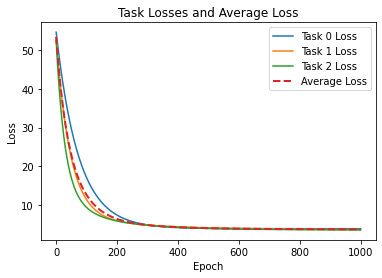

In [12]:


# Load and plot each task loss

all_task_losses = []
fig, ax = plt.subplots()
for key in task_loss.keys():
    # Load the NumPy array
    print(key)
    array_loss = task_loss[key]
    
    # Append the task loss to the list
    all_task_losses.append(array_loss)
    
    # Plot the task loss
    plt.plot(array_loss, label='Task ' + key + ' Loss')

# Calculate and plot the average loss
average_loss = np.mean(all_task_losses, axis=0)
plt.plot(average_loss, label='Average Loss', linestyle='--', linewidth=2)

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Task Losses and Average Loss')
plt.legend()

# Show the plot
plt.show()

In [13]:
# No communications: 199:   Acc:   0.703992,     Loss:    6.676421

# FML_Sheaves  199:   Acc:   0.693134,     Loss:    6.912853   lamda = 1e-2 eta =  1e-1

#  199:   Acc:   0.697911,     Loss:    6.807663 lamda = 1e-2 eta =  2 * 1e-1

# 199:   Acc:   0.701095,     Loss:    6.738724  lamda = 1e-2 eta =  5 * 1e-1

# 199:   Acc:   0.702233,     Loss:    6.712512

# 349:   Acc:   0.784416,     Loss:    4.644473

# No communications 349:   Acc:   0.786272,     Loss:    4.513819

# 349:   Acc:   0.786272,     Loss:    4.515857

In [14]:
test_loss = np.array(losses)




np.save( 'training_loss_sheave_fml' + str(lamda).replace('.', '_')+ '_pout' + str(pout).replace('.', '_'), test_loss)
np.save( 'in_cluster_proj_norm_sheave_fml' + str(lamda).replace('.', '_')+ '_pout' + str(pout).replace('.', '_'), in_cluster_proj_norm)
np.save('out_cluster_proj_norm_sheave_fml' + str(lamda).replace('.', '_')+ '_pout' + str(pout).replace('.', '_'), out_cluster_proj_norm)
np.save( 'in_cluster_proj_diff_norm_sheave_fml' + str(lamda).replace('.', '_')+ '_pout' + str(pout).replace('.', '_'), in_cluster_proj_diff_norm)
np.save('out_cluster_proj_diff_norm_sheave_fml' + str(lamda).replace('.', '_')+ '_pout' + str(pout).replace('.', '_'), out_cluster_proj_diff_norm)

In [15]:
'training_loss_sheave_fml' + str(lamda).replace('.', '_')+ '_pout' + str(pout).replace('.', '_')

'training_loss_sheave_fml0_01_pout0_1'

In [16]:
diagonal_values = np.random.randn(3)
neighbors_mat = np.diag(diagonal_values)
neighbors_mat = np.pad(neighbors_mat, ((0, 0), (0, 2)), mode='constant')
neighbors_mat

array([[ 0.95457384,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.00645671,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.21486642,  0.        ,  0.        ]])